# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict

from statsmodels.regression.linear_model import OLS
from sklearn.metrics import r2_score, accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def loadPrices(fn):
    global nt, nInst
    df = pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    (nt, nInst) = df.shape
    return (df.values).T

# Load Data

In [4]:
prcAll = loadPrices('prices.txt')

NUM_STOCKS = prcAll.shape[0]

# Build Models

In [5]:
def get_log_returns(prices):
    # get log_returns
    # put into pandas
    prices_df = pd.DataFrame(prices).T
    # turn into log returns
    log_return_df = prices_df.pct_change().apply(lambda x: np.log(1+x)).shift(-1)

    for stock_i in range(nInst+1):
        log_return_df[f'forward_1_{stock_i}'] = np.log(prices_df[stock_i]/prices_df[stock_i].shift(1)).shift(-1)
        log_return_df[f'close_to_close (t-{5})(t0)_'+str(stock_i)] = np.log(prices_df[stock_i]/prices_df[stock_i].shift(5))
            
    for stock_i in range(nInst+1):
        for stock_j in range(stock_i+1, nInst+1):
            log_return_df[f'diff_forward_{1}_{stock_i}_{stock_j}'] = log_return_df[f'forward_{1}_{stock_i}'] - log_return_df[f'forward_{1}_{stock_j}']
            log_return_df[f'diff_close_to_close (t-{5})(t0)_'+str(stock_i)+'_'+str(stock_j)] = log_return_df[f'close_to_close (t-{5})(t0)_{stock_i}'] - log_return_df[f'close_to_close (t-{5})(t0)_{stock_j}']

    return log_return_df

In [6]:
def feature_engineer(prices):
    
    # add market which is the mean of all returns
    prices = np.vstack((prices, prices.mean(axis=0)))

    log_return_df = get_log_returns(prices)
    # feature engineering

    # for stock_id in range(nInst+1):
        # create lags
        # log_return_df['lag1_'+str(stock_id)] = log_return_df[stock_id].shift(1)
        # log_return_df['lag2_'+str(stock_id)] = log_return_df[stock_id].shift(2)
        
        # create MA
        # log_return_df['ma5_'+str(stock_id)] = log_return_df[stock_id].rolling(window=5).mean().shift(1)
        # log_return_df['ma10_'+str(stock_id)] = log_return_df[stock_id].rolling(window=10).mean().shift(1)
        # log_return_df['ma20_'+str(stock_id)] = log_return_df[stock_id].rolling(window=20).mean().shift(1)

    log_return_df.rename(columns={stock_id:str(stock_id) for stock_id in range(nInst+1)}, inplace=True)
        
    
    return log_return_df

In [7]:
log_return_df = feature_engineer(prcAll)

In [42]:
test = log_return_df[[str(i) for i in range(50)]].dropna()

In [58]:
corr = np.corrcoef(test.iloc[:250].T)

In [62]:
for i in range(50):
    for j in range(i+1, 50):
        if abs(corr[i][j]) >= 0.3:
            print((i, j, corr[i][j]))

(8, 27, 0.3345148799498058)
(8, 38, 0.3624000759188813)
(12, 27, 0.30157366573860284)
(12, 38, 0.34020848782119184)
(16, 27, 0.4144965085033933)
(16, 38, 0.41878454608541177)
(16, 39, 0.3541063103335155)
(27, 28, 0.3296049901344642)
(27, 38, 0.7040713776337506)
(27, 39, 0.4888064984630813)
(28, 38, 0.39219713656112615)
(29, 38, 0.31506759774374404)
(38, 39, 0.5209640749227075)


In [8]:
TRAIN_LENGTH = 250
TEST_LENGTH = 250
FIRST_TEST_DATE = 250

features = ['close_to_close (t-5)(t0)']
target_column = 'diff_forward_1_'

In [27]:
def build_difference_linear_regression(log_return_df, target_stock, features, test_start_date, train_length):

    data = log_return_df[[f'{target_column}{target_stock[0]}_{target_stock[1]}']+[f'{_}_{target_stock[0]}' for _ in features]+[f'{_}_{target_stock[1]}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock[0]}_{target_stock[1]}']
    X = data.drop(columns=[f'{target_column}{target_stock[0]}_{target_stock[1]}'])
    X = X.assign(const=1)

    # build models
    model = OLS(y, X).fit()

    return model

def inference_difference_linear_regression(log_return_df, model, target_stock, features, test_start_date, train_length):
    
    X = log_return_df[[f'{_}_{target_stock[0]}' for _ in features]+[f'{_}_{target_stock[1]}' for _ in features]].iloc[-1:]

    X = X.assign(const=1)
    
    pred_t1 = model.predict(X).values[0]

    return pred_t1

def predict_train_difference(log_return_df, model, target_stock, features, test_start_date, train_length):
    
    data = log_return_df[[f'{target_column}{target_stock[0]}_{target_stock[1]}']+[f'{_}_{target_stock[0]}' for _ in features]+[f'{_}_{target_stock[1]}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock[0]}_{target_stock[1]}']
    X = data.drop(columns=[f'{target_column}{target_stock[0]}_{target_stock[1]}'])
    X = X.assign(const=1)

    y_pred = model.predict(X)
    
    return y, y_pred

In [10]:
good_model_dict = defaultdict(dict)
model_accuracy_dict = defaultdict(dict)
model_features_dict = defaultdict(dict)

for i in tqdm(range(NUM_STOCKS+1)):
    for j in range(i+1, NUM_STOCKS+1):

        ma_model = build_difference_linear_regression(log_return_df, [i, j], features, FIRST_TEST_DATE, TRAIN_LENGTH)
        ma_y, ma_pred = predict_train_difference(log_return_df, ma_model, [i, j], features, FIRST_TEST_DATE, TRAIN_LENGTH)

        if abs(ma_model.tvalues.values[0]) >= 2 or abs(ma_model.tvalues.values[len(features)]//2) >= 2:
            good_model_dict[i][j] = ma_model
            model_features_dict[i][j] = features
            model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:01<00:00, 36.94it/s]


In [33]:
for i in range(50):
    for j in model_accuracy_dict[i]:
        print(i, j, model_accuracy_dict[i][j])

0 14 0.5673469387755102
1 7 0.563265306122449
1 25 0.563265306122449
1 42 0.5551020408163265
2 25 0.5510204081632653
2 35 0.5755102040816327
2 39 0.5428571428571428
2 50 0.5265306122448979
3 4 0.5224489795918368
3 20 0.5224489795918368
3 25 0.5591836734693878
3 35 0.5836734693877551
5 18 0.5469387755102041
5 40 0.5224489795918368
5 47 0.6040816326530613
5 48 0.5265306122448979
5 49 0.5918367346938775
6 35 0.5714285714285714
7 15 0.5387755102040817
7 25 0.5755102040816327
7 35 0.5591836734693878
7 42 0.5469387755102041
8 25 0.5591836734693878
8 35 0.5714285714285714
10 46 0.5306122448979592
11 15 0.5265306122448979
11 20 0.5591836734693878
11 25 0.5469387755102041
11 26 0.5265306122448979
11 31 0.5102040816326531
11 35 0.5306122448979592
11 41 0.5265306122448979
12 20 0.5346938775510204
12 21 0.5714285714285714
12 25 0.5551020408163265
12 35 0.5510204081632653
12 42 0.5224489795918368
13 21 0.5061224489795918
14 20 0.5183673469387755
14 25 0.5428571428571428
14 35 0.5755102040816327
15 

In [ ]:
(8, 27, 0.3345148799498058)
(8, 38, 0.3624000759188813)
(12, 27, 0.30157366573860284)
(12, 38, 0.34020848782119184)
(16, 27, 0.4144965085033933)
(16, 38, 0.41878454608541177)
(16, 39, 0.3541063103335155)
(27, 28, 0.3296049901344642)
(27, 38, 0.7040713776337506)
(27, 39, 0.4888064984630813)
(28, 38, 0.39219713656112615)
(29, 38, 0.31506759774374404)
(38, 39, 0.5209640749227075)

In [11]:
for i in range(50):
    print(i, good_model_dict[i].keys())

0 dict_keys([32, 50])
1 dict_keys([42])
2 dict_keys([9, 28])
3 dict_keys([23, 38, 50])
4 dict_keys([41])
5 dict_keys([18, 20, 27, 28, 38, 47, 48, 49])
6 dict_keys([10, 11, 36])
7 dict_keys([9, 12, 15, 25])
8 dict_keys([12, 48])
9 dict_keys([])
10 dict_keys([48])
11 dict_keys([19])
12 dict_keys([21])
13 dict_keys([26])
14 dict_keys([20])
15 dict_keys([30, 32, 35])
16 dict_keys([])
17 dict_keys([26])
18 dict_keys([])
19 dict_keys([])
20 dict_keys([22, 36, 47])
21 dict_keys([48])
22 dict_keys([34])
23 dict_keys([])
24 dict_keys([48])
25 dict_keys([34, 35, 38, 39, 44, 50])
26 dict_keys([30])
27 dict_keys([34, 48])
28 dict_keys([45, 48])
29 dict_keys([38])
30 dict_keys([])
31 dict_keys([])
32 dict_keys([48, 49])
33 dict_keys([49])
34 dict_keys([])
35 dict_keys([])
36 dict_keys([])
37 dict_keys([])
38 dict_keys([45])
39 dict_keys([])
40 dict_keys([])
41 dict_keys([])
42 dict_keys([])
43 dict_keys([48])
44 dict_keys([48])
45 dict_keys([46])
46 dict_keys([48])
47 dict_keys([])
48 dict_keys([])

In [34]:
TRAIN_LENGTH = 250
TEST_LENGTH = 250
FIRST_TEST_DATE = 250

features = ['diff_close_to_close (t-5)(t0)']
target_column = 'diff_forward_1_'

In [35]:
def build_difference_linear_regression(log_return_df, target_stock, features, test_start_date, train_length):

    data = log_return_df[[f'{target_column}{target_stock[0]}_{target_stock[1]}']+[f'{_}_{target_stock[0]}_{target_stock[1]}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock[0]}_{target_stock[1]}']
    X = data.drop(columns=[f'{target_column}{target_stock[0]}_{target_stock[1]}'])
    X = X.assign(const=1)

    # build models
    model = OLS(y, X).fit()

    return model

def inference_difference_linear_regression(log_return_df, model, target_stock, features, test_start_date, train_length):
    
    X = log_return_df[[f'{_}_{target_stock[0]}_{target_stock[1]}' for _ in features]].iloc[-1:]

    X = X.assign(const=1)
    
    pred_t1 = model.predict(X).values[0]

    return pred_t1

def predict_train_difference(log_return_df, model, target_stock, features, test_start_date, train_length):
    
    data = log_return_df[[f'{target_column}{target_stock[0]}_{target_stock[1]}']+[f'{_}_{target_stock[0]}_{target_stock[1]}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock[0]}_{target_stock[1]}']
    X = data.drop(columns=[f'{target_column}{target_stock[0]}_{target_stock[1]}'])
    X = X.assign(const=1)

    y_pred = model.predict(X)
    
    return y, y_pred

In [36]:
good_model_dict = defaultdict(dict)
model_accuracy_dict = defaultdict(dict)
model_features_dict = defaultdict(dict)

for i in tqdm(range(NUM_STOCKS+1)):
    for j in range(i+1, NUM_STOCKS+1):

        ma_model = build_difference_linear_regression(log_return_df, [i, j], features, FIRST_TEST_DATE, TRAIN_LENGTH)
        ma_y, ma_pred = predict_train_difference(log_return_df, ma_model, [i, j], features, FIRST_TEST_DATE, TRAIN_LENGTH)

        if abs(ma_model.tvalues.values[0]) >= 2 or abs(ma_model.tvalues.values[len(features)]//2) >= 2:
            good_model_dict[i][j] = ma_model
            model_features_dict[i][j] = features
            model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

100%|██████████| 51/51 [00:01<00:00, 38.10it/s]


In [ ]:
(8, 27, 0.3345148799498058)
(8, 38, 0.3624000759188813)
(12, 27, 0.30157366573860284)
(12, 38, 0.34020848782119184)
(16, 27, 0.4144965085033933)
(16, 38, 0.41878454608541177)
(16, 39, 0.3541063103335155)
(27, 28, 0.3296049901344642)
(27, 38, 0.7040713776337506)
(27, 39, 0.4888064984630813)
(28, 38, 0.39219713656112615)
(29, 38, 0.31506759774374404)
(38, 39, 0.5209640749227075)

In [15]:
for i in range(50):
    print(i, good_model_dict[i].keys())

0 dict_keys([14])
1 dict_keys([7, 25, 42])
2 dict_keys([25, 35, 39, 50])
3 dict_keys([4, 20, 25, 35])
4 dict_keys([])
5 dict_keys([18, 40, 47, 48, 49])
6 dict_keys([35])
7 dict_keys([15, 25, 35, 42])
8 dict_keys([25, 35])
9 dict_keys([])
10 dict_keys([46])
11 dict_keys([15, 20, 25, 26, 31, 35, 41])
12 dict_keys([20, 21, 25, 35, 42])
13 dict_keys([21])
14 dict_keys([20, 25, 35])
15 dict_keys([45])
16 dict_keys([25, 35, 47, 50])
17 dict_keys([25, 35])
18 dict_keys([25, 35])
19 dict_keys([])
20 dict_keys([22, 47])
21 dict_keys([25, 35])
22 dict_keys([])
23 dict_keys([25, 35])
24 dict_keys([35])
25 dict_keys([])
26 dict_keys([42])
27 dict_keys([35, 39, 50])
28 dict_keys([35])
29 dict_keys([35])
30 dict_keys([])
31 dict_keys([49])
32 dict_keys([35])
33 dict_keys([35, 41])
34 dict_keys([35, 41])
35 dict_keys([41])
36 dict_keys([])
37 dict_keys([])
38 dict_keys([47, 50])
39 dict_keys([])
40 dict_keys([])
41 dict_keys([])
42 dict_keys([47, 50])
43 dict_keys([46])
44 dict_keys([])
45 dict_keys(

In [37]:
for i in range(50):
    for j in model_accuracy_dict[i]:
        print(i, j, model_accuracy_dict[i][j])

0 14 0.5673469387755102
1 7 0.563265306122449
1 25 0.563265306122449
1 42 0.5551020408163265
2 25 0.5510204081632653
2 35 0.5755102040816327
2 39 0.5428571428571428
2 50 0.5265306122448979
3 4 0.5224489795918368
3 20 0.5224489795918368
3 25 0.5591836734693878
3 35 0.5836734693877551
5 18 0.5469387755102041
5 40 0.5224489795918368
5 47 0.6040816326530613
5 48 0.5265306122448979
5 49 0.5918367346938775
6 35 0.5714285714285714
7 15 0.5387755102040817
7 25 0.5755102040816327
7 35 0.5591836734693878
7 42 0.5469387755102041
8 25 0.5591836734693878
8 35 0.5714285714285714
10 46 0.5306122448979592
11 15 0.5265306122448979
11 20 0.5591836734693878
11 25 0.5469387755102041
11 26 0.5265306122448979
11 31 0.5102040816326531
11 35 0.5306122448979592
11 41 0.5265306122448979
12 20 0.5346938775510204
12 21 0.5714285714285714
12 25 0.5551020408163265
12 35 0.5510204081632653
12 42 0.5224489795918368
13 21 0.5061224489795918
14 20 0.5183673469387755
14 25 0.5428571428571428
14 35 0.5755102040816327
15 

# Backtest

## Define Strategy

In [16]:
def build_models_for_this_period(log_return_df, first_start_date):

    good_model_dict = defaultdict(dict)
    model_accuracy_dict = defaultdict(dict)
    model_features_dict = defaultdict(dict)

    for i in range(NUM_STOCKS+1):
        for j in range(i+1, NUM_STOCKS+1):
            
            ma_model = build_difference_linear_regression(log_return_df, [i, j], features, first_start_date, TRAIN_LENGTH)
            ma_y, ma_pred = predict_train_difference(log_return_df, ma_model, [i, j], features, first_start_date, TRAIN_LENGTH)

            if abs(ma_model.tvalues.values[0]) >= 2 or abs(ma_model.tvalues.values[len(features)]//2) >= 2:
                good_model_dict[i][j] = ma_model
                model_features_dict[i][j] = features
                model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

    final_model_dict = defaultdict(dict)

    for stock_i in model_accuracy_dict:
        top_10 = sorted(model_accuracy_dict[stock_i].items(), key=lambda x: x[1], reverse=True)
        for stock_j, score in top_10:
            
            if stock_j in good_model_dict[stock_i]: # Todo: in future take average, or take average of votes?
                final_model_dict[stock_i][stock_j] = good_model_dict[stock_i][stock_j]

    return final_model_dict, model_features_dict

In [17]:
def getMyPosition(prcSoFar):
    
    global currentPos, final_model_dict, old_model_dict, model_features_dict, no_signal, total_signals, first_start_date

    
    if prcSoFar.shape[1] == START_DATE+250: # last day don't make any new positions
        return currentPos

    log_return_df = feature_engineer(prcSoFar)

    # retrain model every 50 days
    if prcSoFar.shape[1] % TEST_LENGTH == 0:
        first_start_date = prcSoFar.shape[1]

        final_model_dict, model_features_dict = build_models_for_this_period(log_return_df, first_start_date)

    #     if prcSoFar.shape[1] != 250: # TODO: hardcoded restore no-trade positions to 0
    #         for stock_i in old_model_dict:
    #             if stock_i not in final_model_dict:
    #                 currentPos[stock_i] = 0
    
        # old_model_dict = final_model_dict
    
    signal = np.zeros(50)

    # make predictions
    for stock_i in final_model_dict:
        for stock_j in final_model_dict[stock_i]:
            
            stock_i_j_prediction = inference_difference_linear_regression(log_return_df,
                                    final_model_dict[stock_i][stock_j],
                                    [stock_i,
                                    stock_j],
                                    model_features_dict[stock_i][stock_j],
                                    first_start_date,
                                    TRAIN_LENGTH)

            if stock_i_j_prediction > 0: 
                signal[stock_i] += 1
                if stock_j != 50:
                    signal[stock_j] -= 1
            elif stock_i_j_prediction < 0:
                signal[stock_i] -= 1
                if stock_j != 50:
                    signal[stock_j] += 1
     

    for stock_i in final_model_dict:
        if signal[stock_i] > 0:
            currentPos[stock_i] += 1000/prcSoFar[stock_i, -1]
        elif signal[stock_i] < -0:
            currentPos[stock_i] -= 1000/prcSoFar[stock_i, -1]
        
    return currentPos

## Run

In [28]:
BACKBONE_MODEL = 'multivariate'

TRAIN_LENGTH = 250
TEST_LENGTH = 250

features = ['close_to_close (t-5)(t0)']
# features = ['diff_close_to_close (t-5)(t0)']
target_column = 'diff_forward_1_'

In [29]:
START_DATE = 250

signals = np.zeros([50, 251])
positions = np.zeros([50, 251])
returns = np.zeros([50, 251])

values_array = np.zeros([50, 251])
cash_array = np.zeros([50, 251])
commission_array = np.zeros([50, 251])
todayPL_array = np.zeros([50, 251])
no_signal = 0
total_signals = 0

commRate = 0.0010
dlrPosLimit = 10000

nInst = 50
currentPos = np.zeros(nInst)

def calcPL(prcHist):
    global pll
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_, nt) = prcHist.shape
    for t in range(250, 501): # t will go from 250 to 500 (251 numbers)
        prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
        newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
        deltaPos = newPos - curPos # t0 change position
        
        positions[:, prcHistSoFar.shape[1]-START_DATE] = newPos # record position
        
        dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume 
        comm = dvolume * commRate # t0 commission
        cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

        commission_array[:, prcHistSoFar.shape[1]-START_DATE] = curPrices*np.abs(deltaPos) * commRate

        cash_array[:, prcHistSoFar.shape[1]-START_DATE] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == START_DATE \
              else cash_array[:, prcHistSoFar.shape[1]-START_DATE-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

        curPos = np.array(newPos) 
        posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
        todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
        if t != START_DATE+250:
            returns[:, prcHistSoFar.shape[1]-START_DATE] = prcHist[:, t] / prcHist[:, t-1] - 1
            todayPL_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices if t == START_DATE \
                else cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-START_DATE-1]

        todayPLL.append(todayPL) 
        value = cash + posValue

        values_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices

        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
              (t, value, todayPL, totDVolume, ret))
    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)


(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

Day 250 value: -27.00 todayPL: $-27.00 $-traded: 27000 return: -0.00100
Day 251 value: -26.59 todayPL: $0.41 $-traded: 53000 return: -0.00050
Day 252 value: -84.43 todayPL: $-57.85 $-traded: 77000 return: -0.00110
Day 253 value: -142.60 todayPL: $-58.16 $-traded: 104000 return: -0.00137
Day 254 value: -277.78 todayPL: $-135.18 $-traded: 130000 return: -0.00214
Day 255 value: -347.35 todayPL: $-69.57 $-traded: 155000 return: -0.00224
Day 256 value: -395.60 todayPL: $-48.25 $-traded: 184000 return: -0.00215
Day 257 value: -288.52 todayPL: $107.08 $-traded: 210000 return: -0.00137
Day 258 value: -233.04 todayPL: $55.48 $-traded: 236000 return: -0.00099
Day 259 value: -197.22 todayPL: $35.83 $-traded: 260870 return: -0.00076
Day 260 value: 76.81 todayPL: $274.03 $-traded: 286990 return: 0.00027
Day 261 value: 290.52 todayPL: $213.70 $-traded: 309615 return: 0.00094
Day 262 value: 108.00 todayPL: $-182.52 $-traded: 331357 return: 0.00033
Day 263 value: -107.04 todayPL: $-215.04 $-traded: 35

In [20]:
df_rows = []
for STOCK in range(50):

    for i in range(251):
        df_rows.append({
            'Signal': int(np.sign(signals[STOCK][i])),
            'Price': prcAll[STOCK][i+249],
            'Price x Positions': prcAll[STOCK][i+249] * positions[STOCK][i],
            'Change in positions': np.round(positions[STOCK][i]-positions[STOCK][i-1], 1) if i != 0 else np.round(positions[STOCK][i], 1),
            'Positions': np.round(positions[STOCK][i], 1),
            'PnL': np.round(todayPL_array[STOCK][i], 2),
            'PnL + Commission': np.round(todayPL_array[STOCK][i]+commission_array[STOCK][i], 2),
            'Returns': np.round(returns[STOCK][i], 4),
            'Commission': np.round(commission_array[STOCK][i], 2),
            'Stock': STOCK,
            'Day': i+250})
            # 'audit_PnL': returns[STOCK][i] * positions[STOCK][i] * prcAll[STOCK][i+249]})

audit_df = pd.DataFrame(df_rows)
audit_df.to_excel('audit_table.xlsx')

In [21]:
# START_DATE = 500

# signals = np.zeros([50, 251])
# positions = np.zeros([50, 251])
# returns = np.zeros([50, 251])

# values_array = np.zeros([50, 251])
# cash_array = np.zeros([50, 251])
# todayPL_array = np.zeros([50, 251])

# commRate = 0.0010
# dlrPosLimit = 10000

# nInst = 50
# currentPos = np.zeros(nInst)

# def calcPL(prcHist):
#     global pll
#     cash = 0
#     curPos = np.zeros(nInst)
#     totDVolume = 0
#     totDVolumeSignal = 0
#     totDVolumeRandom = 0
#     value = 0
#     todayPLL = []
#     (_, nt) = prcHist.shape
#     for t in range(500, 751): # t will go from 250 to 500 (251 numbers)
#         prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
#         newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
#         curPrices = prcHistSoFar[:, -1]
#         posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
#         newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
#         deltaPos = newPos - curPos # t0 change position
        
#         positions[:, prcHistSoFar.shape[1]-START_DATE] = newPos # record position
        
#         dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
#         dvolume = np.sum(dvolumes)
#         totDVolume += dvolume 
#         comm = dvolume * commRate # t0 commission
#         cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

#         cash_array[:, prcHistSoFar.shape[1]-START_DATE] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == START_DATE \
#               else cash_array[:, prcHistSoFar.shape[1]-START_DATE-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

#         curPos = np.array(newPos) 
#         posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
#         todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
#         if t != START_DATE+250:
#             returns[:, prcHistSoFar.shape[1]-START_DATE] = prcHist[:, t] / prcHist[:, t-1] - 1
#             todayPL_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices if t == START_DATE \
#                 else cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-START_DATE-1]

#         todayPLL.append(todayPL) 
#         value = cash + posValue

#         values_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices

#         ret = 0.0
#         if (totDVolume > 0):
#             ret = value / totDVolume
#         print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
#               (t, value, todayPL, totDVolume, ret))
#     pll = np.array(todayPLL)
#     (plmu, plstd) = (np.mean(pll), np.std(pll))
#     annSharpe = 0.0
#     if (plstd > 0):
#         annSharpe = np.sqrt(250) * plmu / plstd
#     return (plmu, ret, plstd, annSharpe, totDVolume)


# (meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
# score = meanpl - 0.1*plstd
# print("=====")
# print("mean(PL): %.1lf" % meanpl)
# print("return: %.5lf" % ret)
# print("StdDev(PL): %.2lf" % plstd)
# print("annSharpe(PL): %.2lf " % sharpe)
# print("totDvolume: %.0lf " % dvol)
# print("Score: %.2lf" % score)

In [22]:
# START_DATE = 750

# signals = np.zeros([50, 251])
# positions = np.zeros([50, 251])
# returns = np.zeros([50, 251])

# values_array = np.zeros([50, 251])
# cash_array = np.zeros([50, 251])
# todayPL_array = np.zeros([50, 251])

# commRate = 0.0010
# dlrPosLimit = 10000

# nInst = 50
# currentPos = np.zeros(nInst)

# def calcPL(prcHist):
#     global pll
#     cash = 0
#     curPos = np.zeros(nInst)
#     totDVolume = 0
#     totDVolumeSignal = 0
#     totDVolumeRandom = 0
#     value = 0
#     todayPLL = []
#     (_, nt) = prcHist.shape
#     for t in range(750, 1001): # t will go from 250 to 500 (251 numbers)
#         prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
#         newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
#         curPrices = prcHistSoFar[:, -1]
#         posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
#         newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
#         deltaPos = newPos - curPos # t0 change position
        
#         positions[:, prcHistSoFar.shape[1]-START_DATE] = newPos # record position
        
#         dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
#         dvolume = np.sum(dvolumes)
#         totDVolume += dvolume 
#         comm = dvolume * commRate # t0 commission
#         cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

#         cash_array[:, prcHistSoFar.shape[1]-START_DATE] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == START_DATE \
#               else cash_array[:, prcHistSoFar.shape[1]-START_DATE-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

#         curPos = np.array(newPos) 
#         posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
#         todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
#         if t != START_DATE+250:
#             returns[:, prcHistSoFar.shape[1]-START_DATE] = prcHist[:, t] / prcHist[:, t-1] - 1
#             todayPL_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices if t == START_DATE \
#                 else cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-START_DATE-1]

#         todayPLL.append(todayPL) 
#         value = cash + posValue

#         values_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices

#         ret = 0.0
#         if (totDVolume > 0):
#             ret = value / totDVolume
#         print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
#               (t, value, todayPL, totDVolume, ret))
#     pll = np.array(todayPLL)
#     (plmu, plstd) = (np.mean(pll), np.std(pll))
#     annSharpe = 0.0
#     if (plstd > 0):
#         annSharpe = np.sqrt(250) * plmu / plstd
#     return (plmu, ret, plstd, annSharpe, totDVolume)


# (meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
# score = meanpl - 0.1*plstd
# print("=====")
# print("mean(PL): %.1lf" % meanpl)
# print("return: %.5lf" % ret)
# print("StdDev(PL): %.2lf" % plstd)
# print("annSharpe(PL): %.2lf " % sharpe)
# print("totDvolume: %.0lf " % dvol)
# print("Score: %.2lf" % score)

# Evaluation

In [23]:
# returns_flatten = returns[:250].flatten()
# signals_flatten = signals[:250].flatten()

# buckets = {}
# for i in range(-51, 51, 5):
#     buckets[(i, i+1)] = [returns_flatten[j] for j in range(len(returns_flatten)) if signals_flatten[j] >= i and signals_flatten[j] < i+1]
# buckets = [(key, np.mean(value)) for key, value in buckets.items()]

# # Extract the mid-point of each bucket range and the mean returns
# bucket_midpoints = [(key[0] + key[1]) / 2 for key, value in buckets]
# bucket_means = [value for key, value in buckets]

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.scatter(bucket_midpoints, bucket_means, color='blue')
# plt.xlabel('Signal Buckets Midpoints')
# plt.ylabel('Mean Returns')
# plt.axvline(x=0, color='r', linestyle='-')
# plt.axhline(y=0, color='r', linestyle='-')
# plt.title('Mean Returns per Signal Bucket')
# plt.grid(True)
# plt.show()

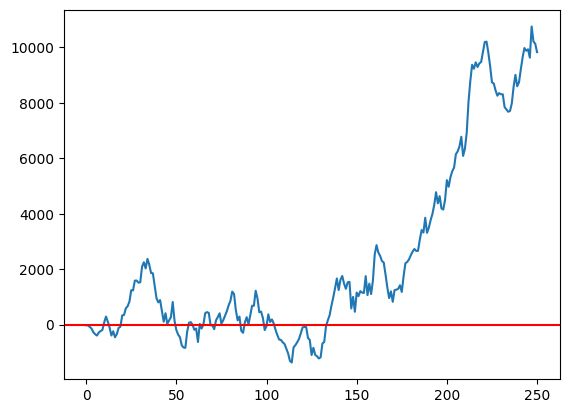

In [30]:
plt.plot(np.cumsum(pll))
plt.axhline(y=0, color='r', linestyle='-')

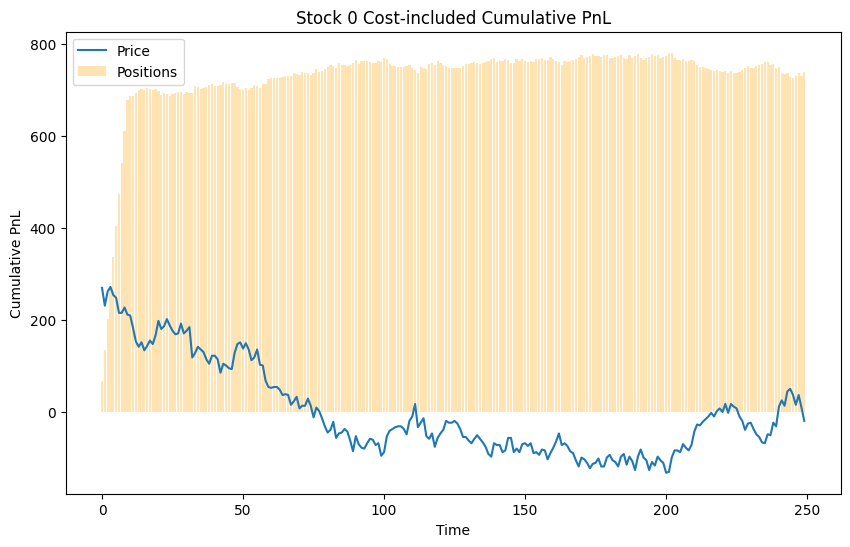

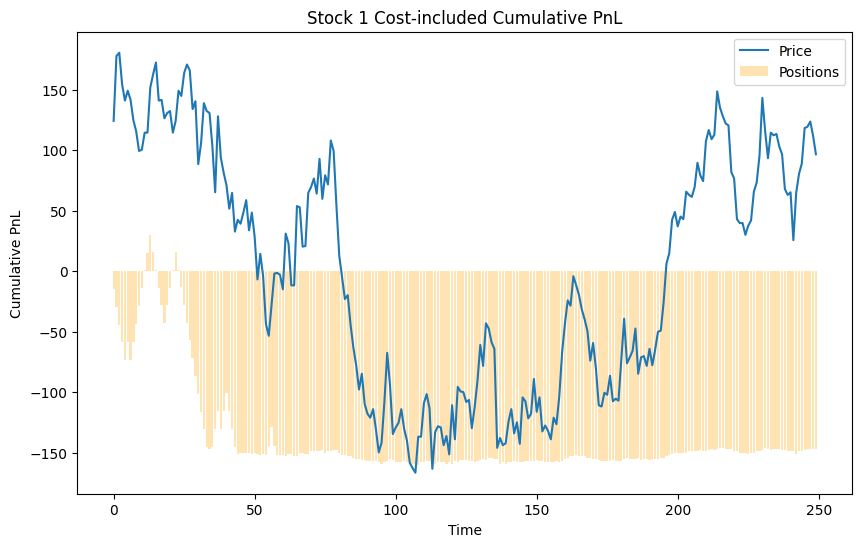

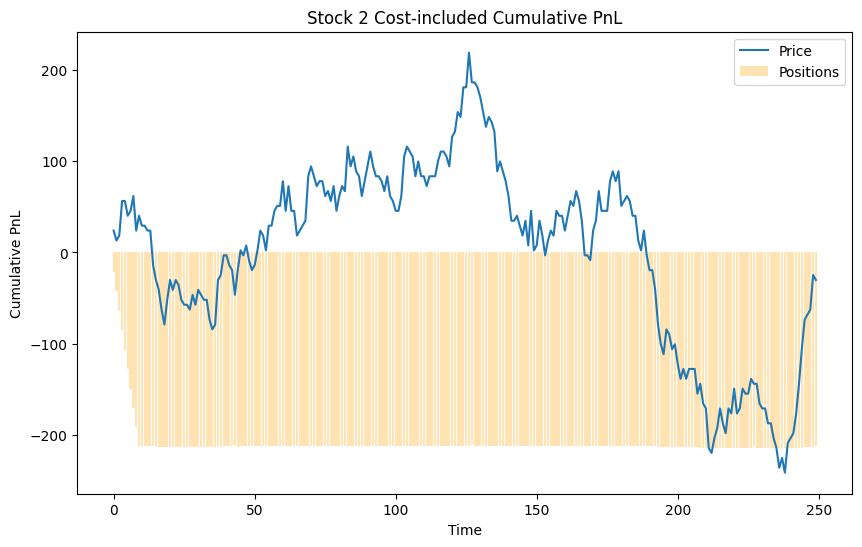

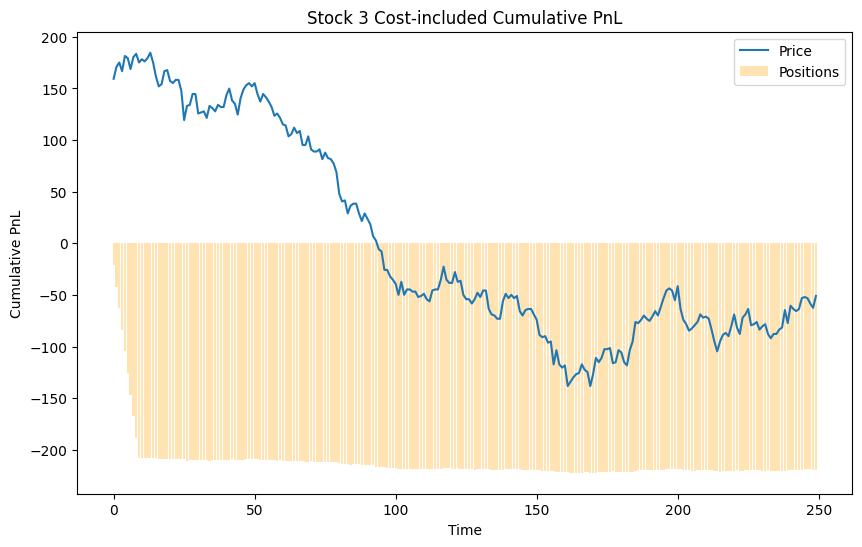

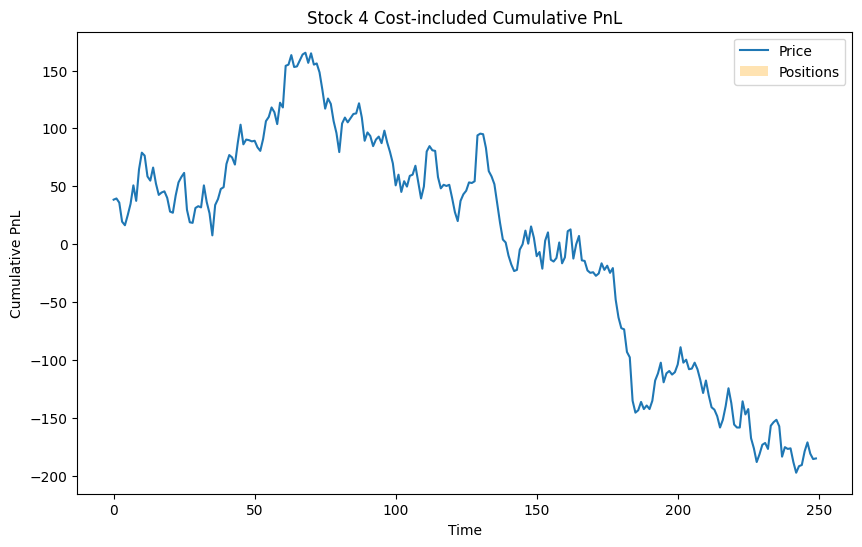

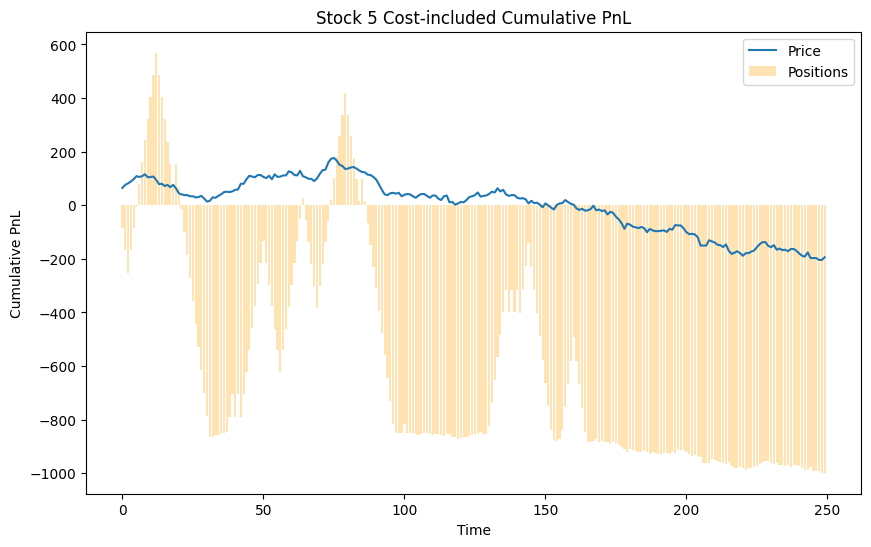

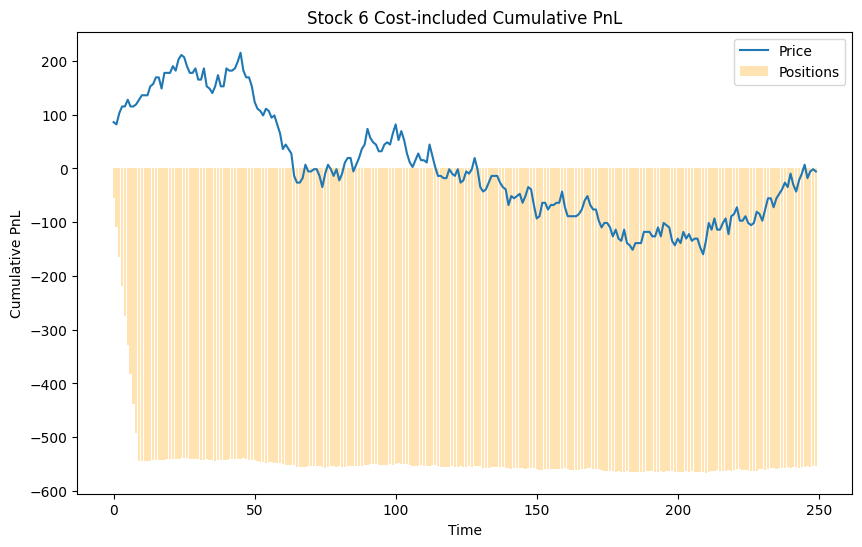

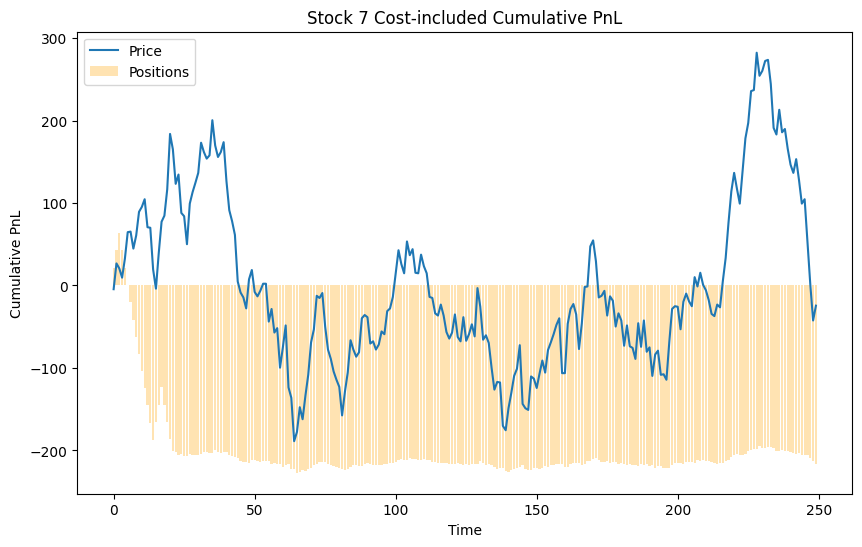

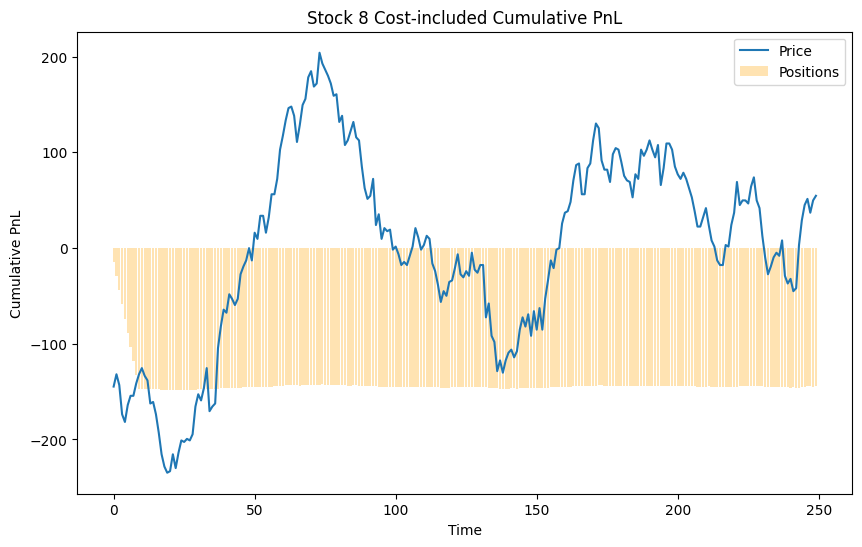

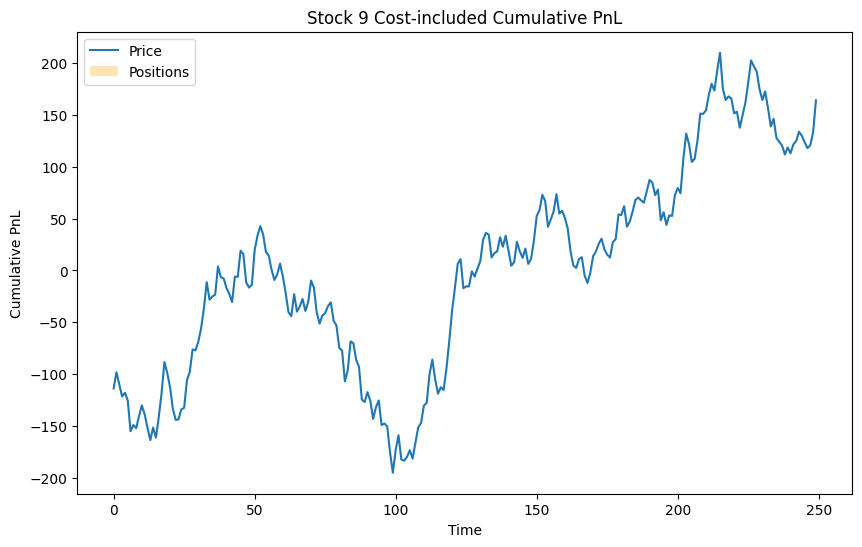

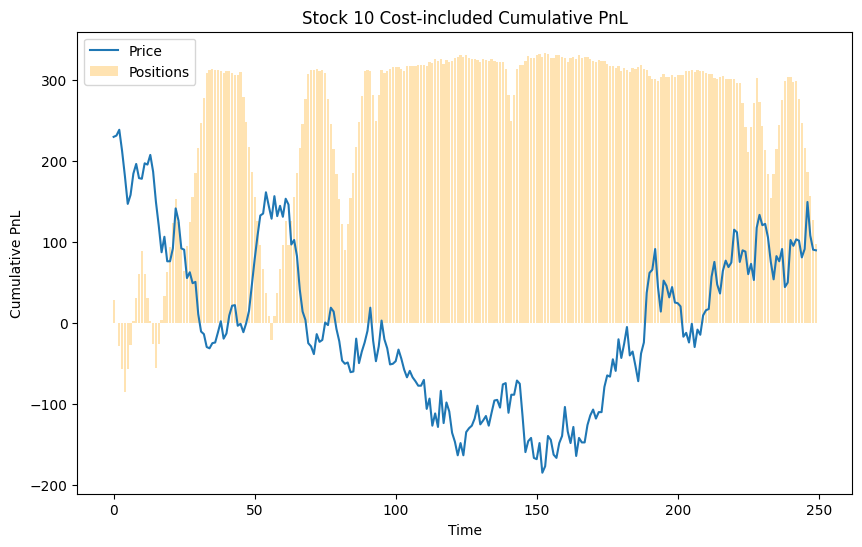

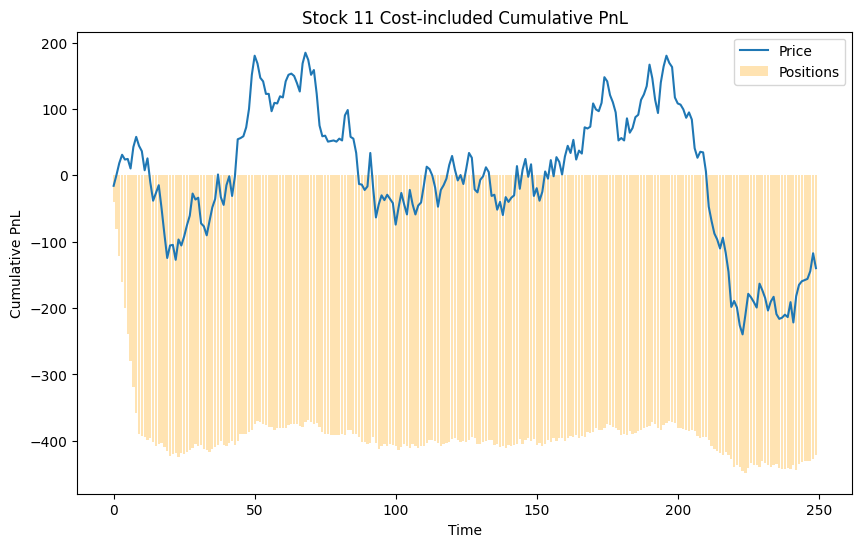

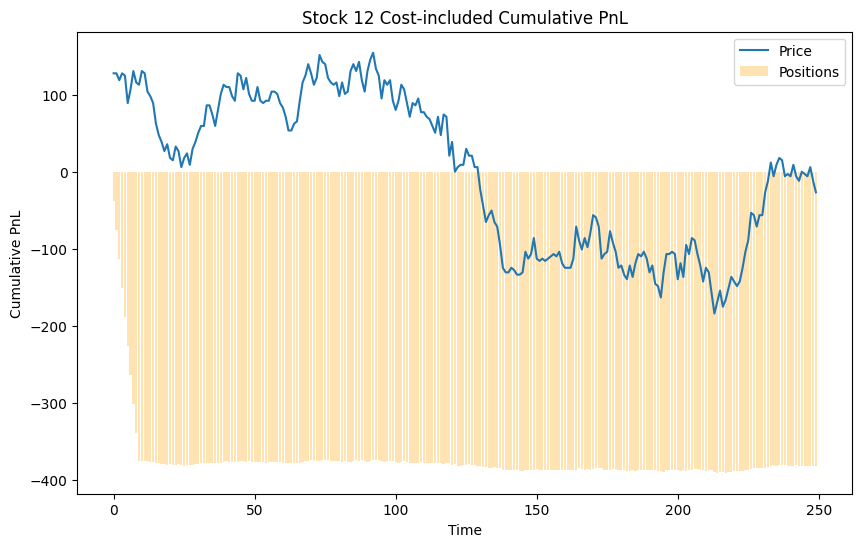

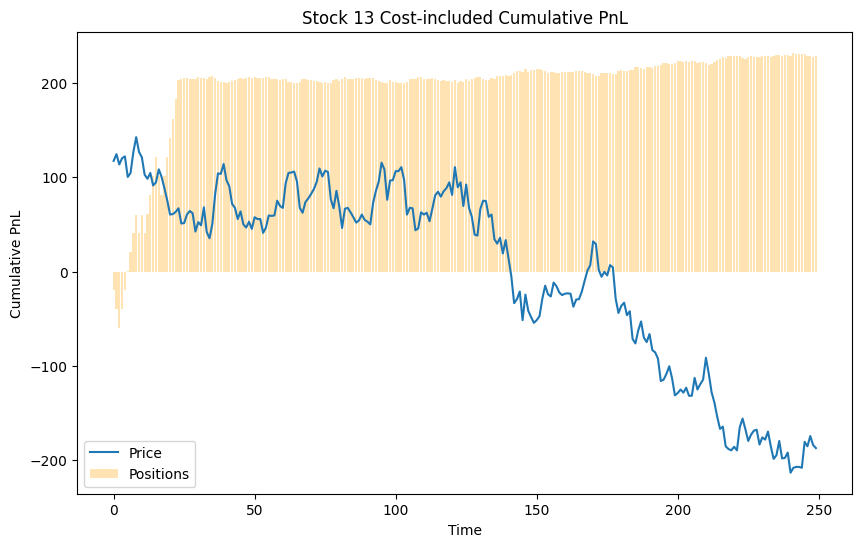

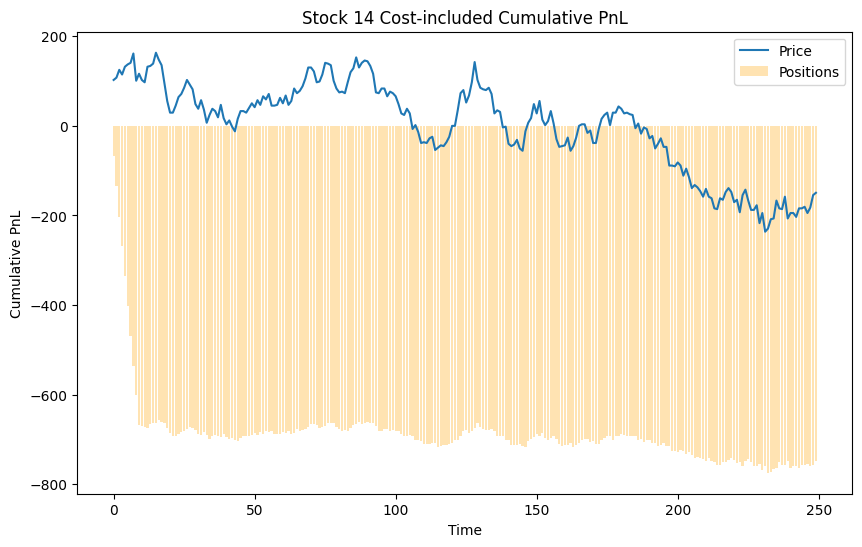

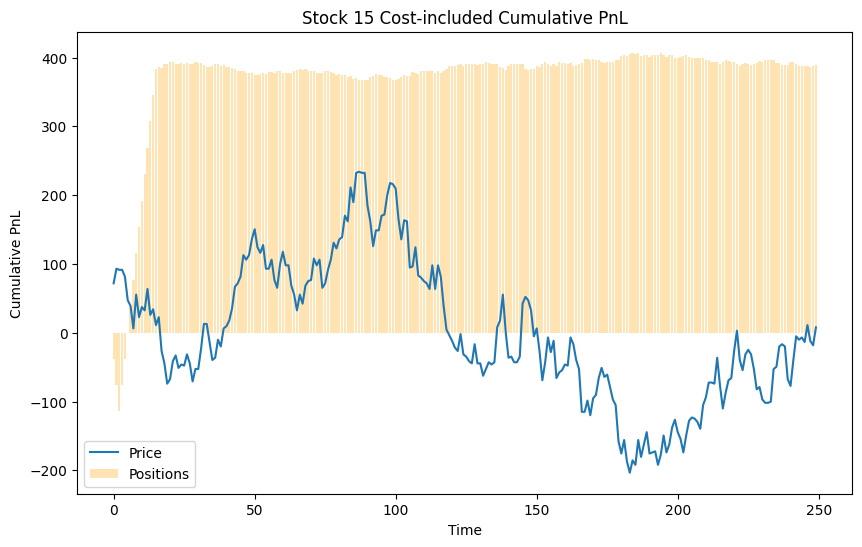

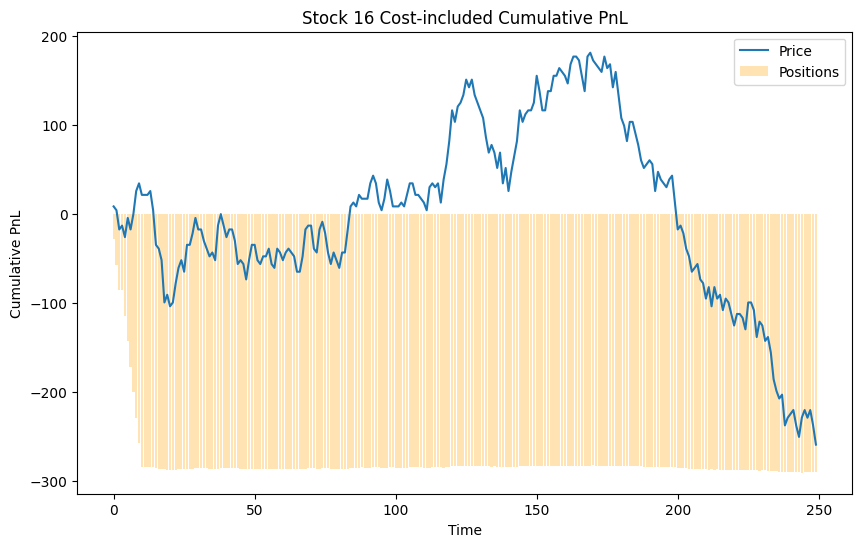

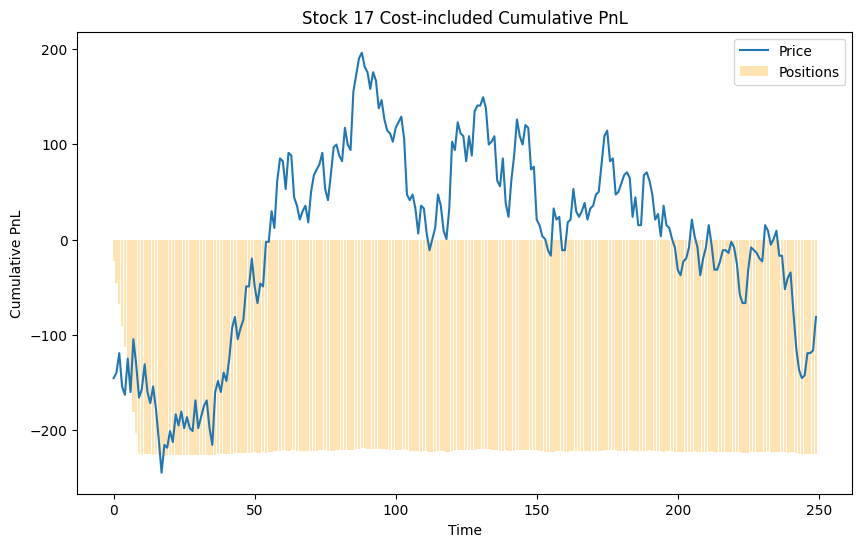

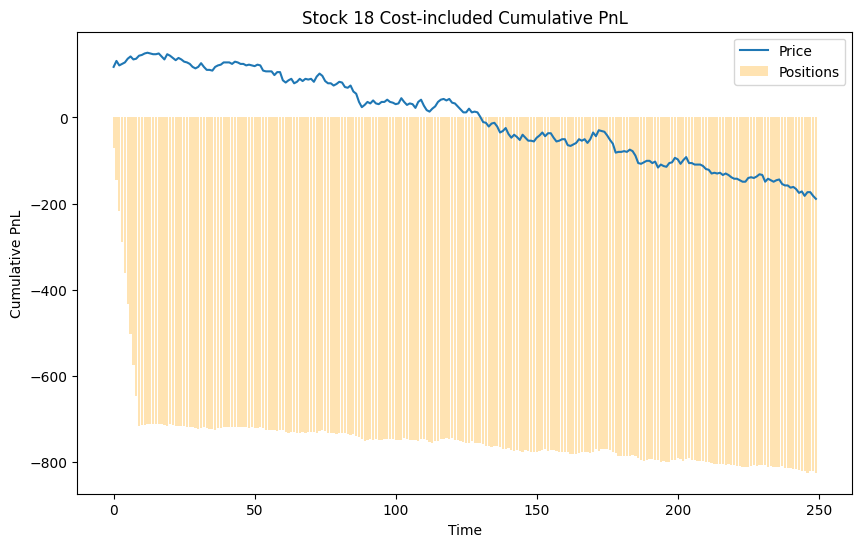

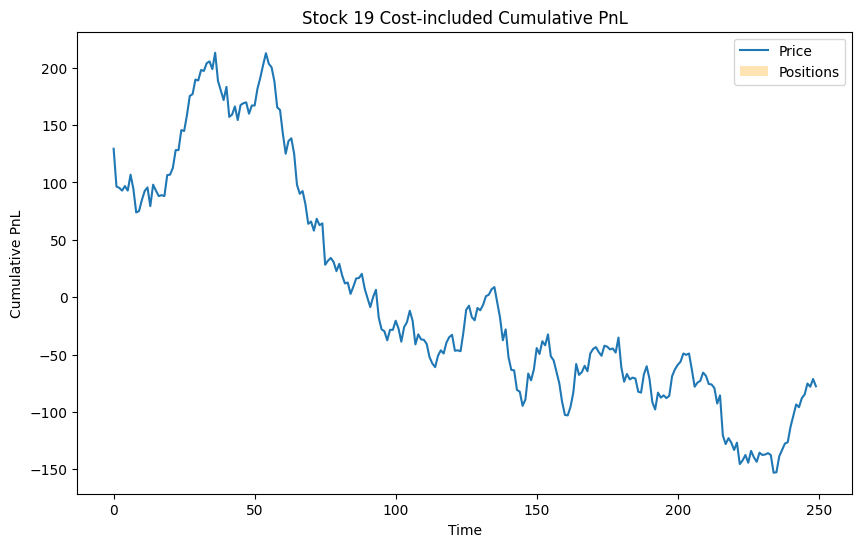

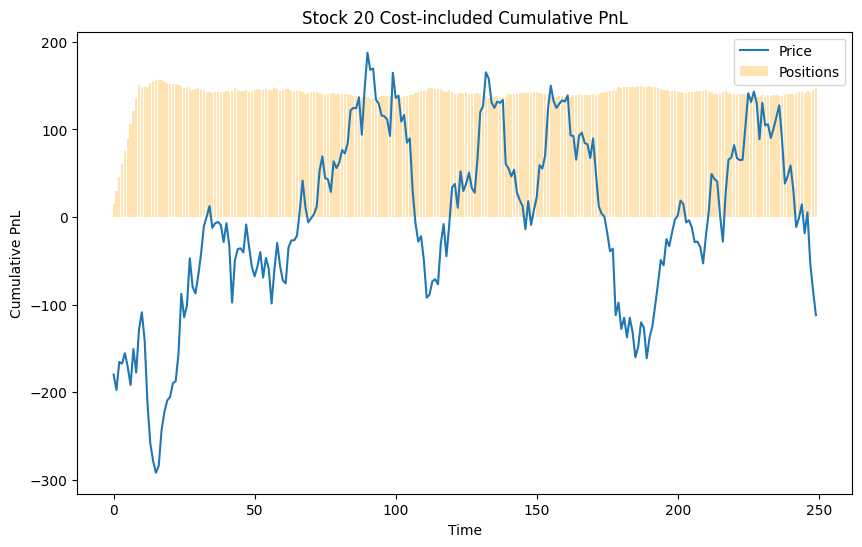

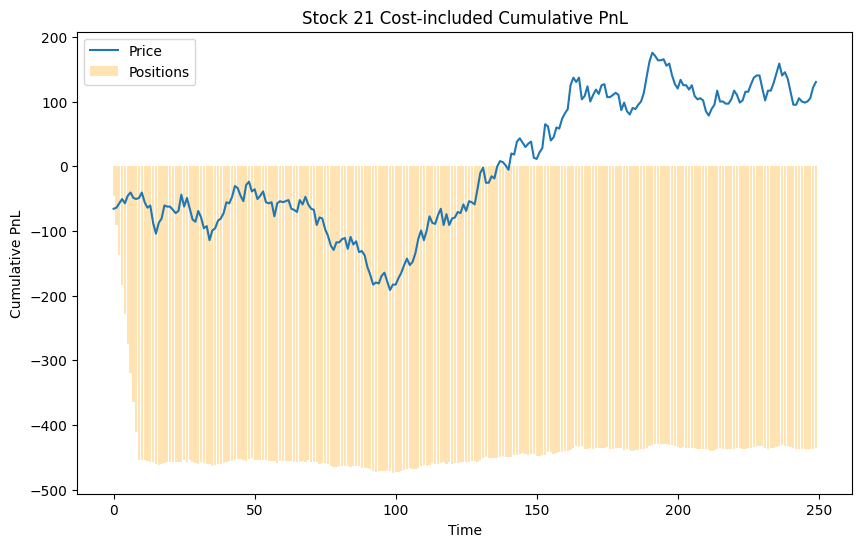

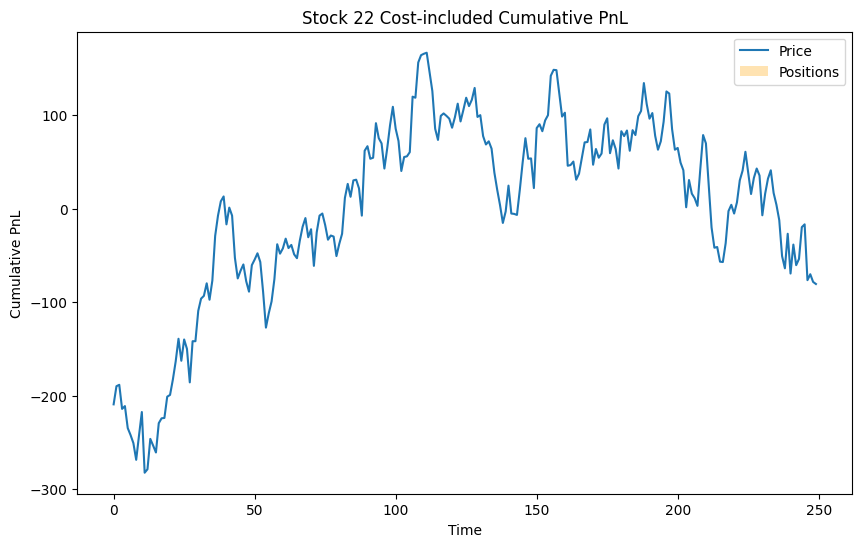

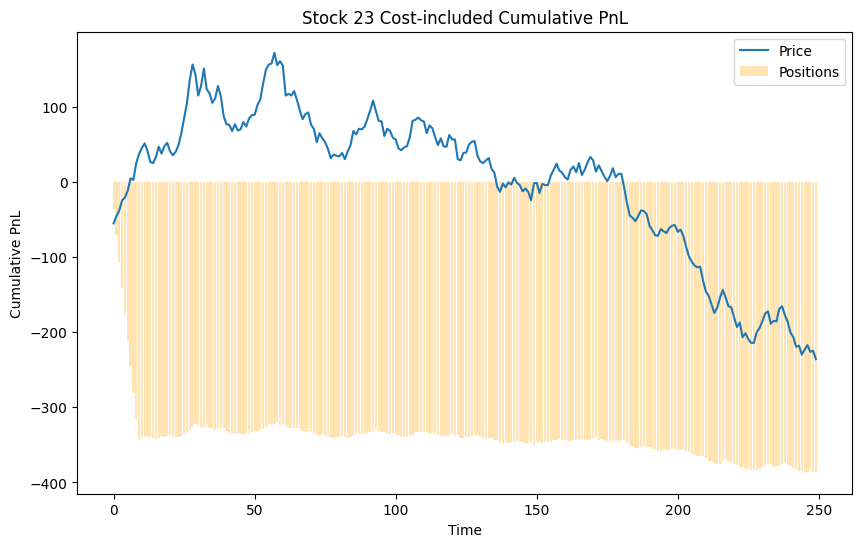

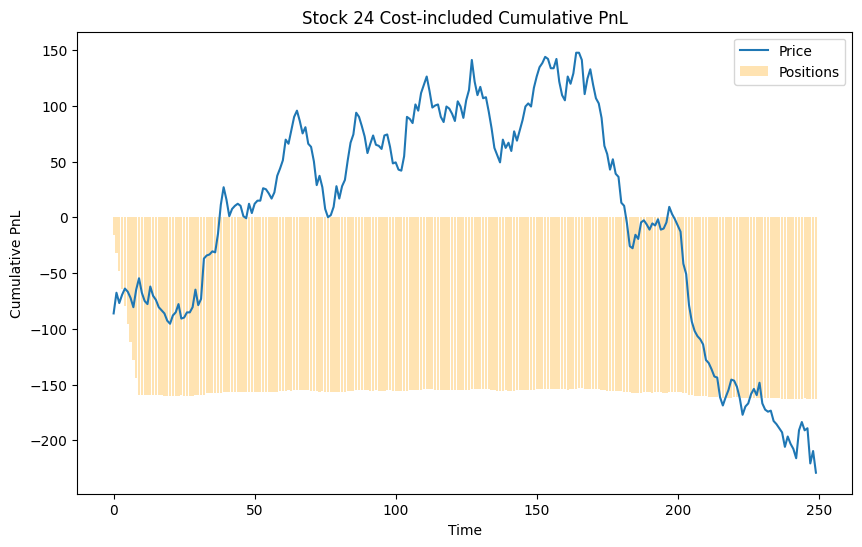

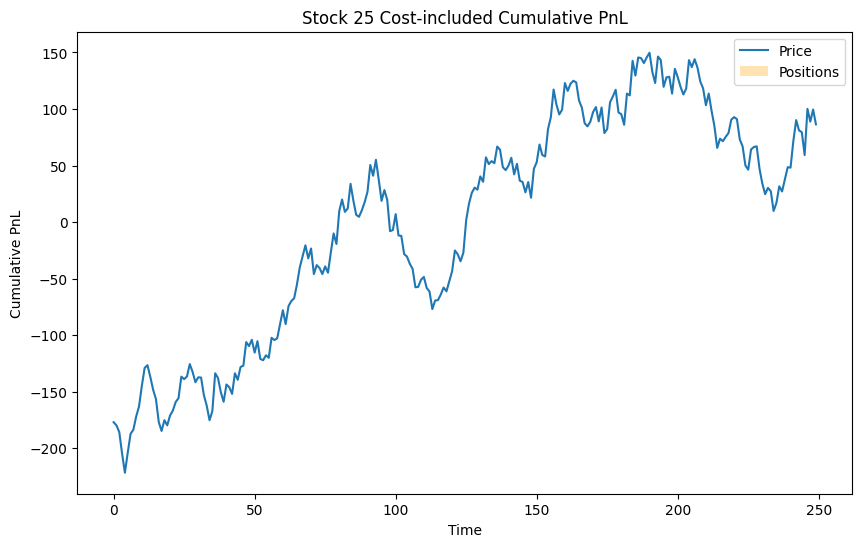

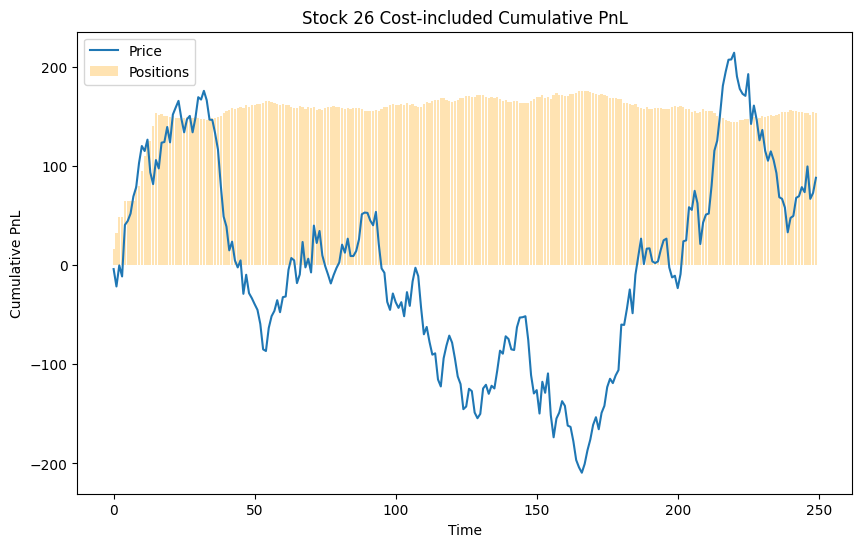

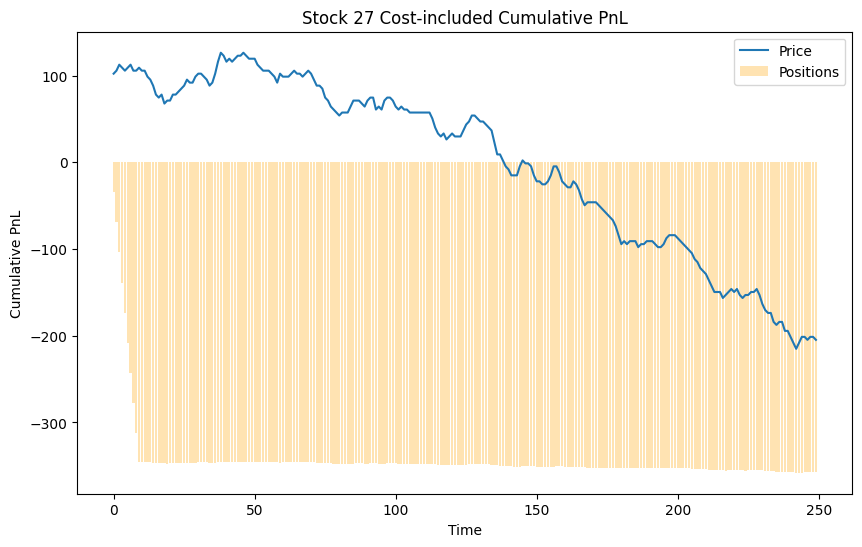

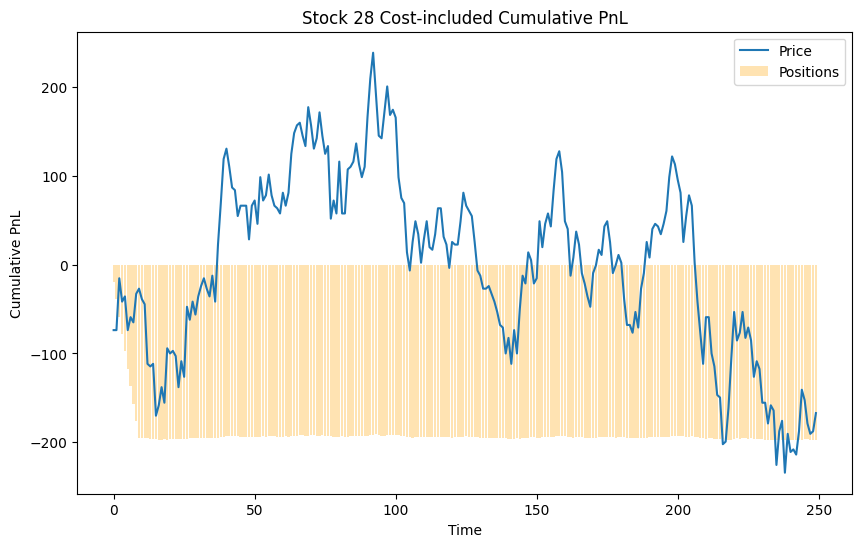

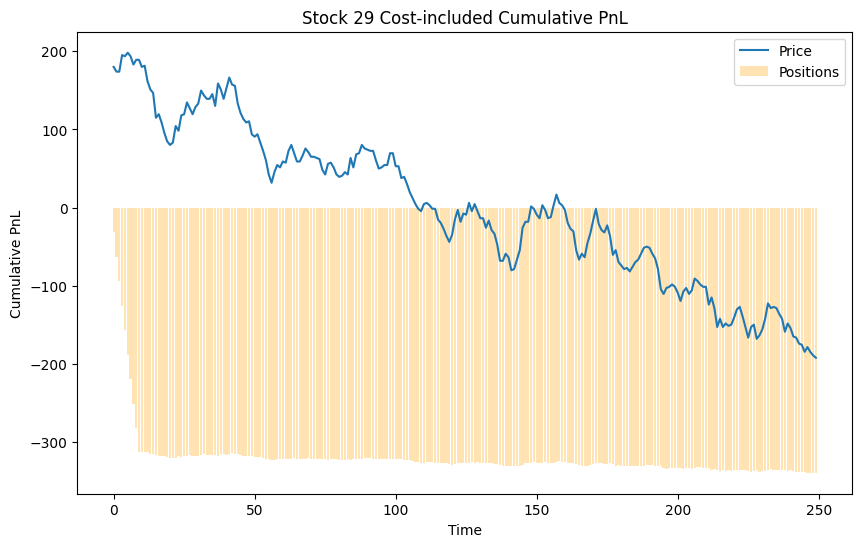

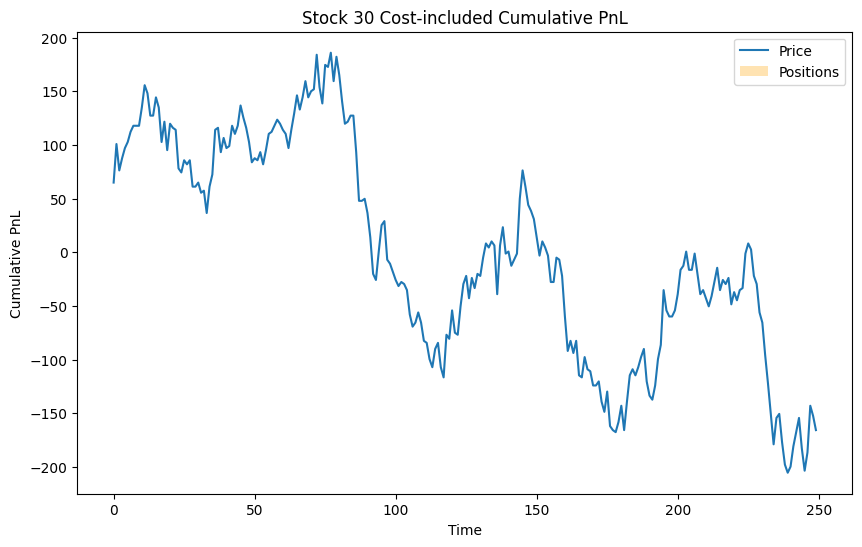

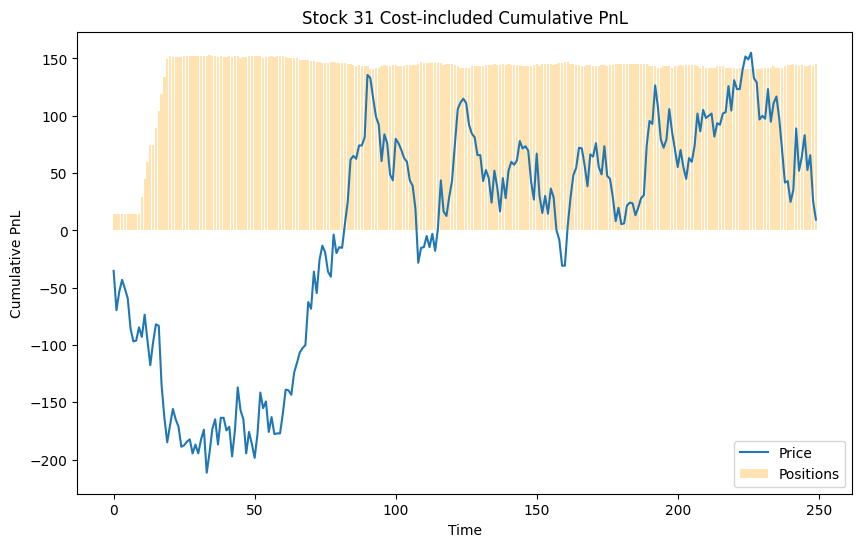

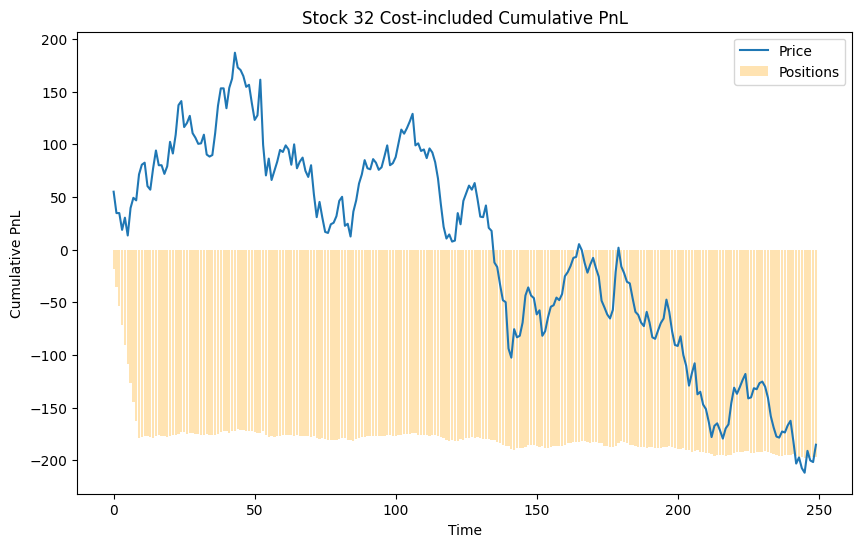

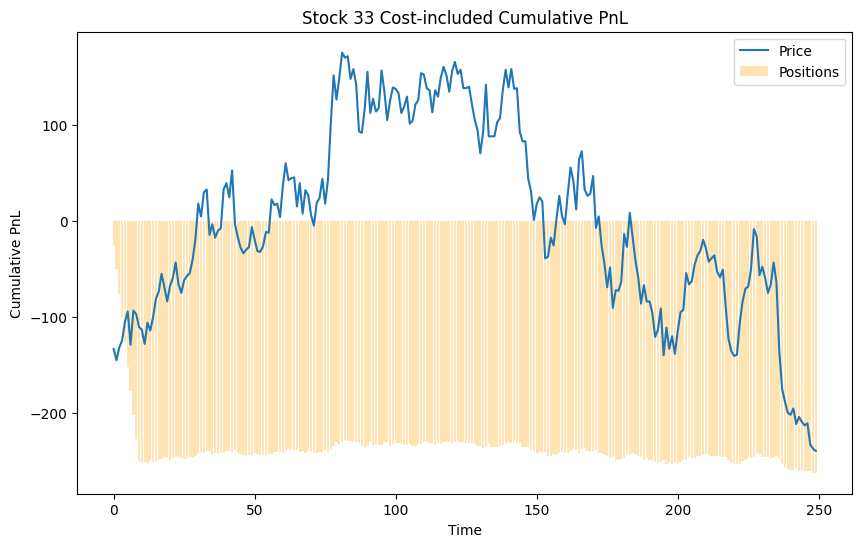

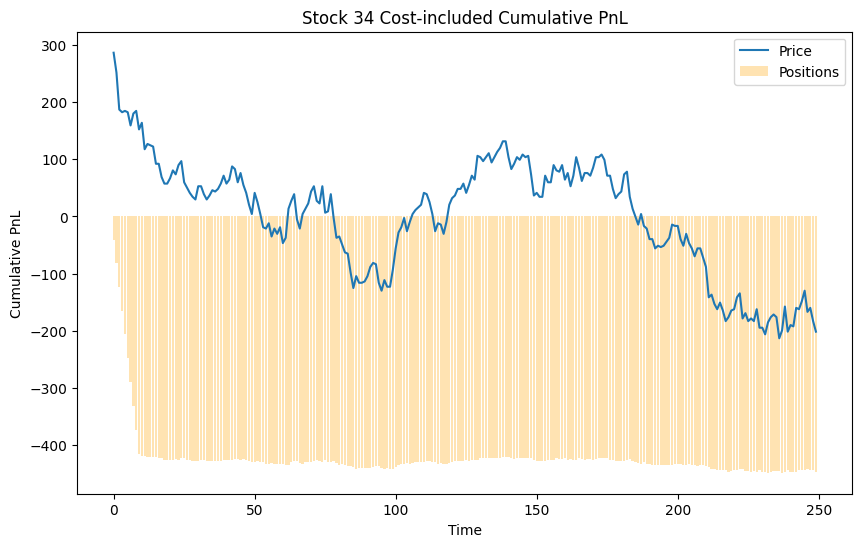

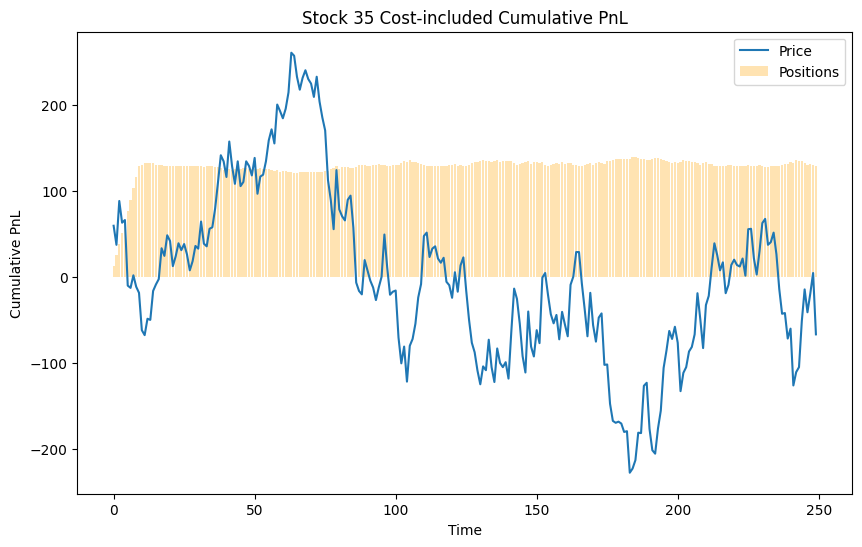

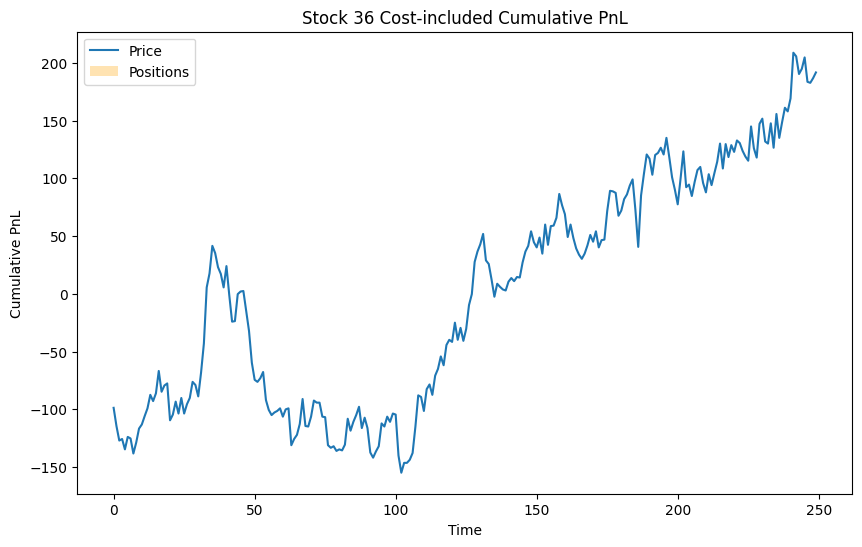

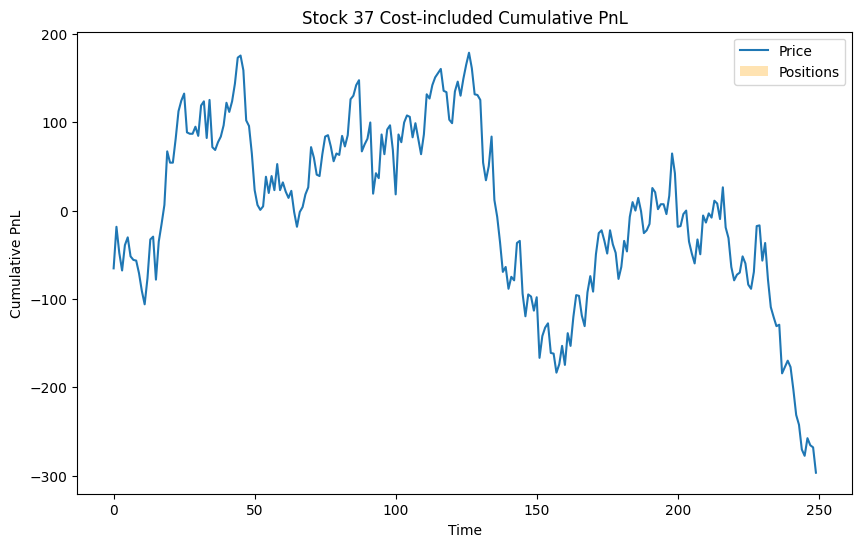

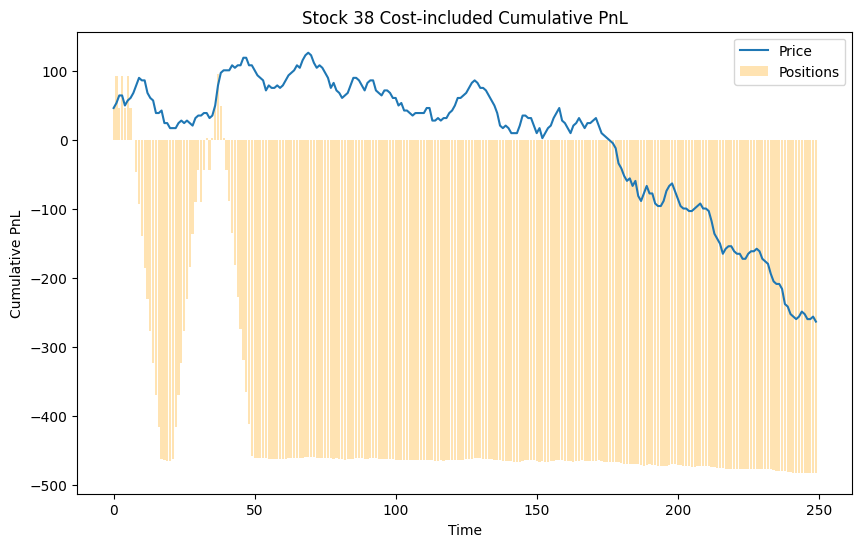

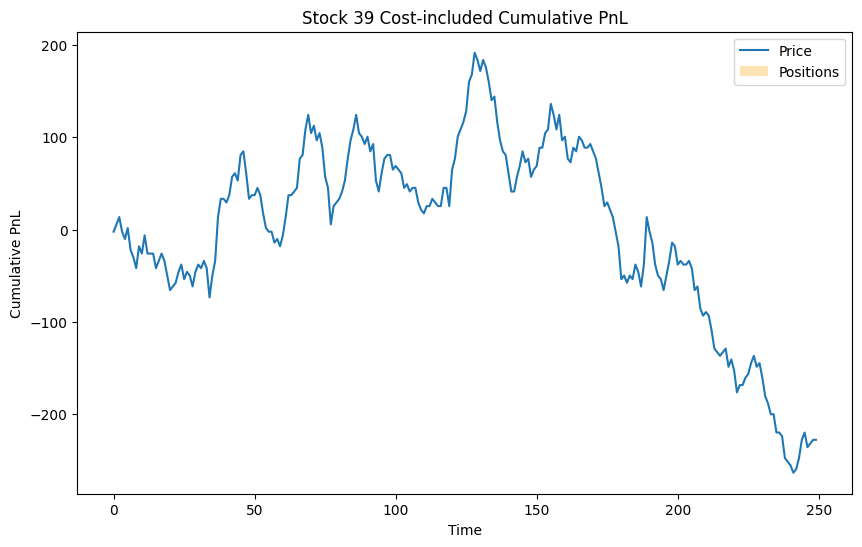

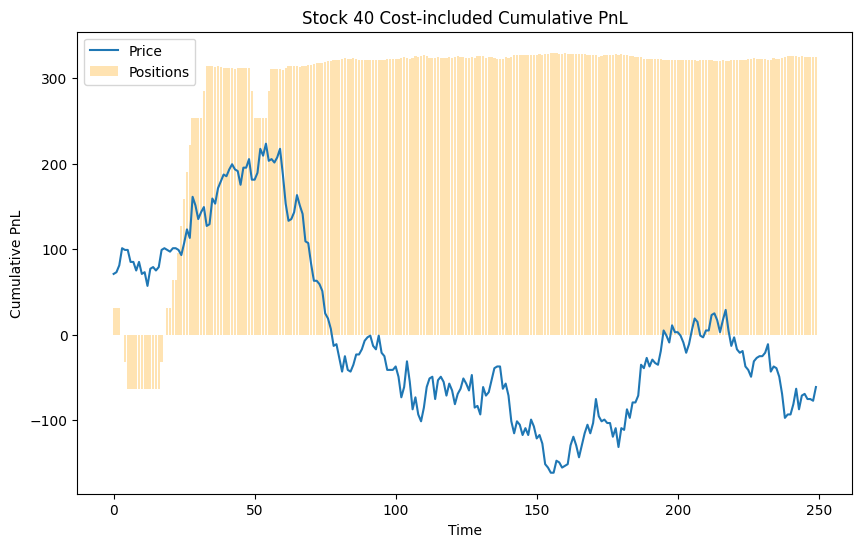

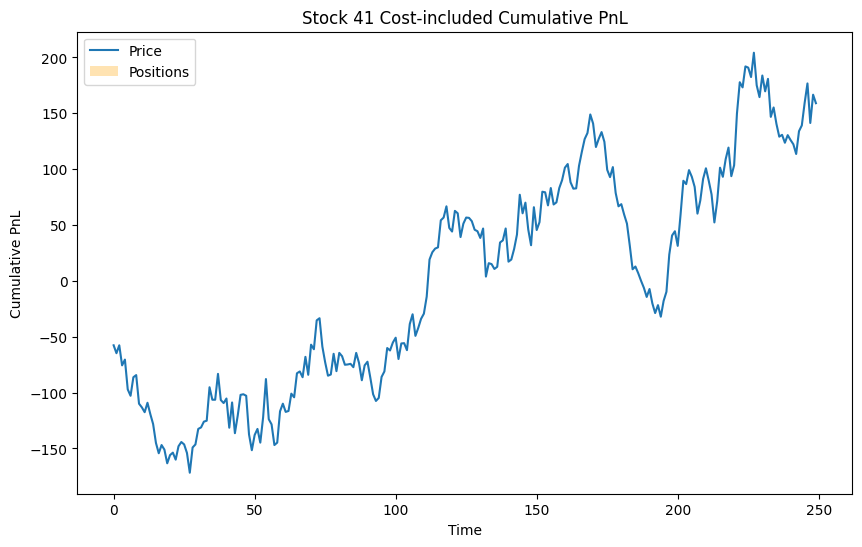

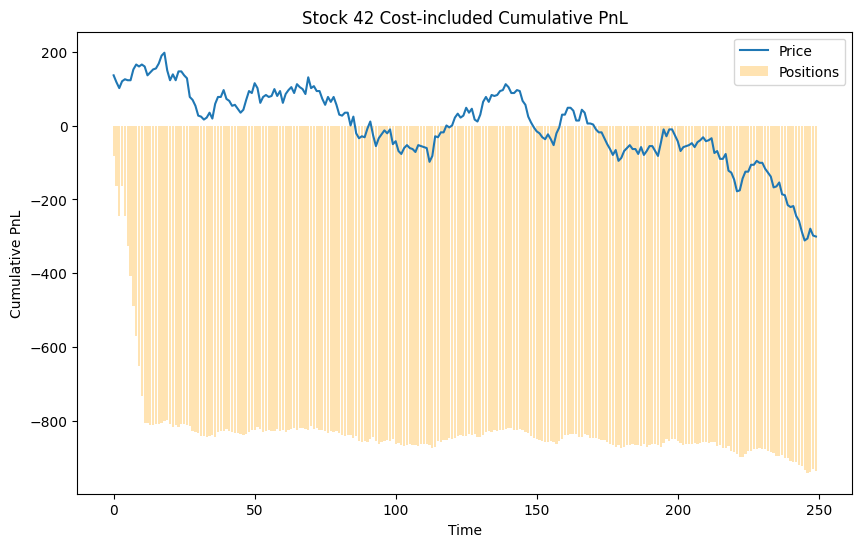

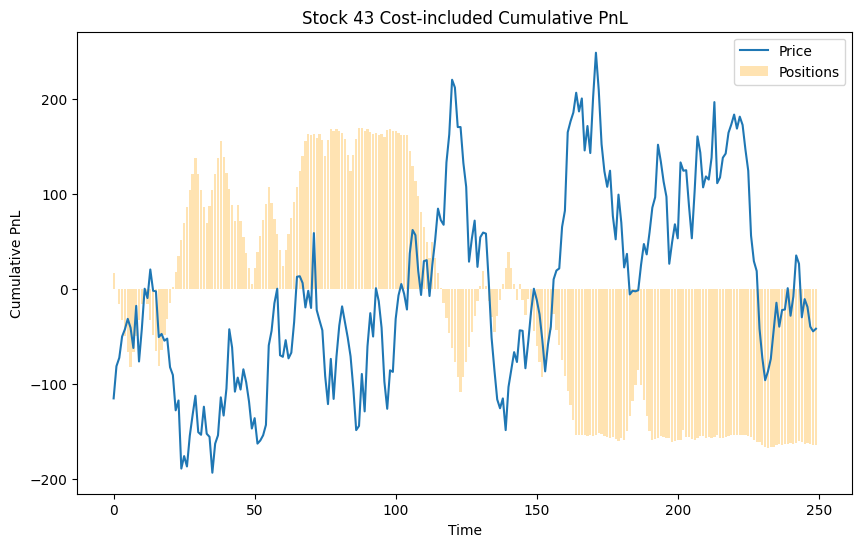

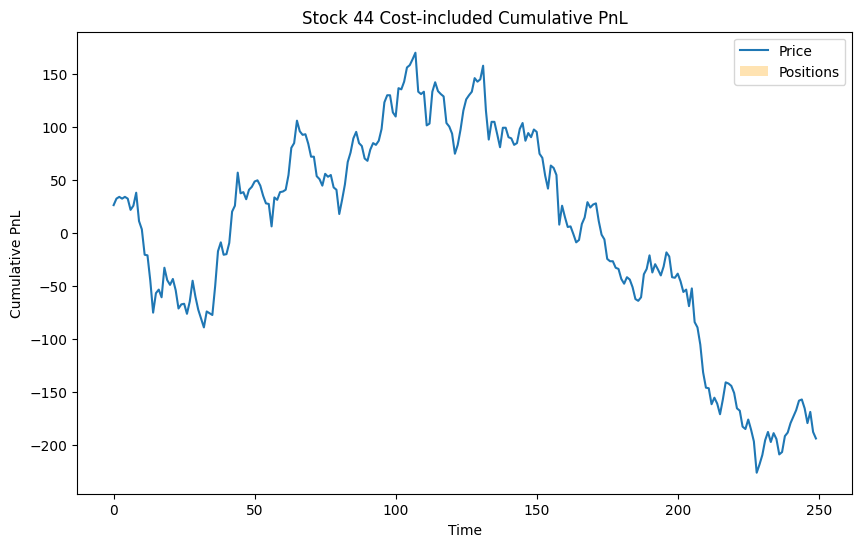

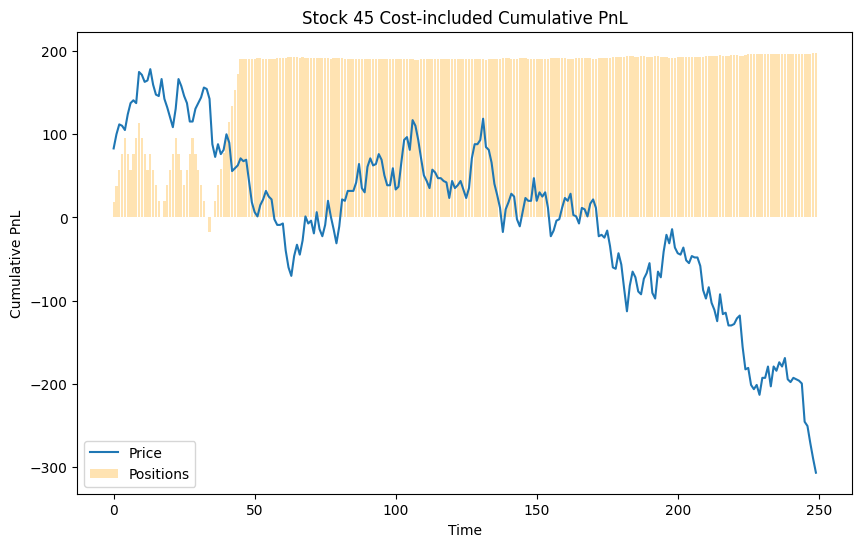

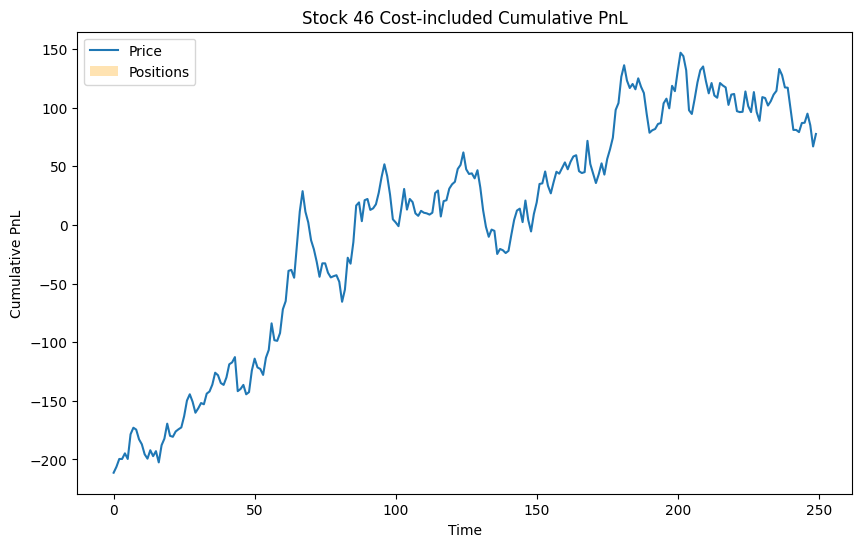

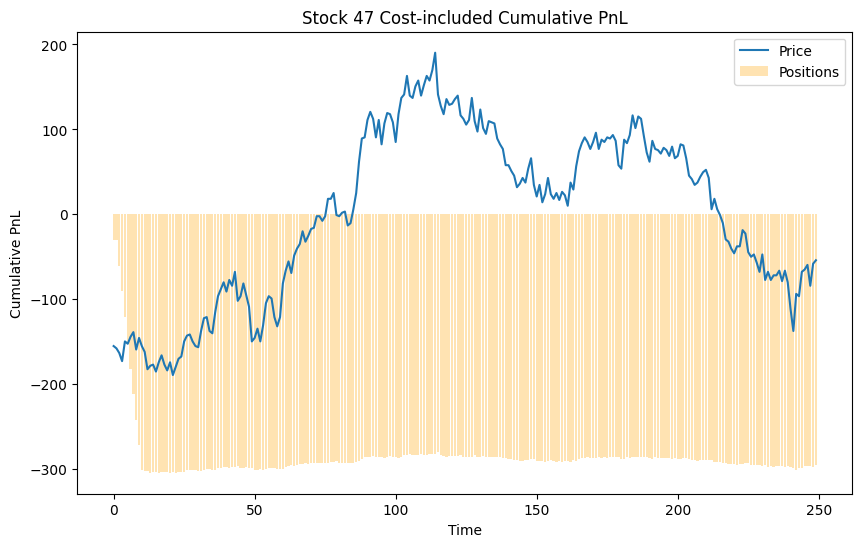

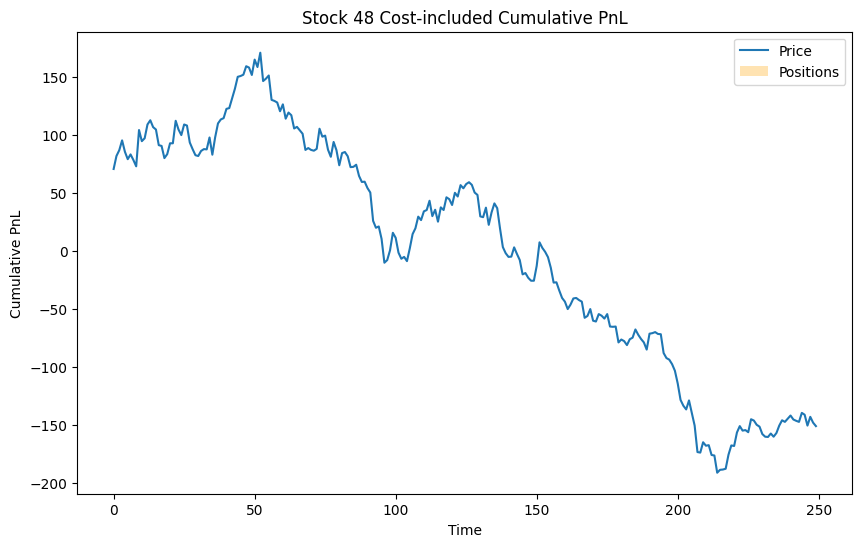

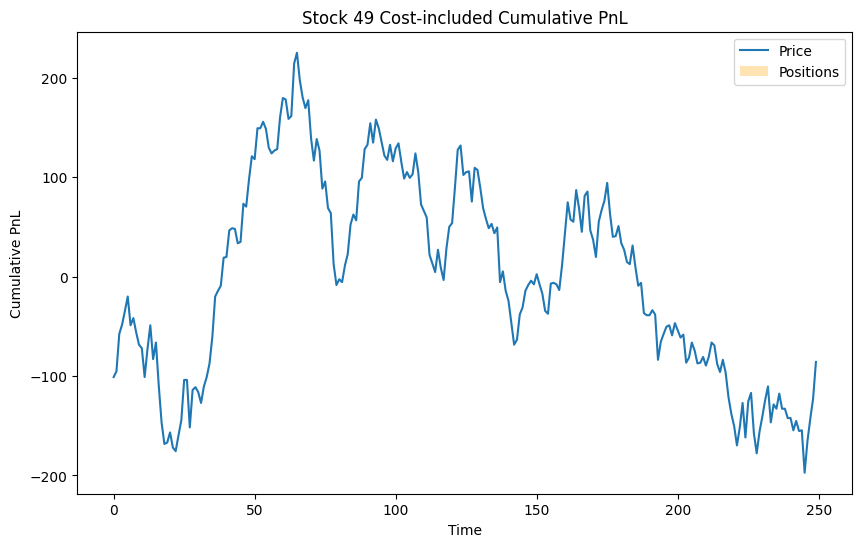

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming todayPL_array and positions are already defined and have appropriate shapes.

for i in range(50):
    plt.figure(figsize=(10, 6))  # Adjust the figure size if necessary
    
    # Plot the cumulative PnL
    plt.plot(100*(prcAll[i, 250:] - np.mean(prcAll[i, 250:]))/np.std(prcAll[i, 250:]), label='Price')
    
    # Add the bar chart at y = 0
    plt.bar(range(250), positions[i, :250], alpha=0.3, label='Positions', color='orange')
    
    # Adding a title and labels
    plt.title(f'Stock {i} Cost-included Cumulative PnL')
    plt.xlabel('Time')
    plt.ylabel('Cumulative PnL')
    
    # Adding a legend
    plt.legend()
    
    # Show the plot
    plt.show()


In [26]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming todayPL_array and positions are already defined and have appropriate shapes.

# for i in range(50):
#     plt.figure(figsize=(10, 6))  # Adjust the figure size if necessary
    
#     # Plot the cumulative PnL
#     plt.plot(np.cumsum(todayPL_array[i, :250]), label='Cumulative PnL')
    
#     # Add the bar chart at y = 0
#     plt.bar(range(250), positions[i, :250], alpha=0.3, label='Positions', color='orange')
    
#     # Adding a title and labels
#     plt.title(f'Stock {i} Cost-included Cumulative PnL')
#     plt.xlabel('Time')
#     plt.ylabel('Cumulative PnL')
    
#     # Adding a legend
#     plt.legend()
    
#     # Show the plot
#     plt.show()


# Graveyard

##### Difference